In [27]:
import torch
CUDA = torch.cuda.is_available()
print(CUDA)

False


In [28]:
import time
from lifelines.utils import concordance_index 
import sys
from torch import nn
import numpy as np
import pandas as pd
import network
from torch.utils.data import TensorDataset, Dataset
import torch.utils.data.dataloader as dataloader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.utils import resample

In [29]:
# WHAS = 1
# GBSG = 2
# METABRIC = 3
# SUPPORT = 4

DATASET_CHOICE = 1

if (DATASET_CHOICE == 1):
    # WHAS
    ds = pd.read_csv('./datasets/whas1638.csv',sep=',')
    train = ds[:1310]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1310:]
    x_train = train[['0','1', '2', '3', '4', '5']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5']].as_matrix() 
elif (DATASET_CHOICE == 2):
    # GBSG
    ds = pd.read_csv('./datasets/gbsg2232.csv',sep=',')
    train = ds[:1546]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1546:]
    x_train = train[['0','1', '2', '3', '4', '5', '6']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6']].as_matrix() 
elif (DATASET_CHOICE == 3):
    # for METABRIC
    ds = pd.read_csv('./datasets/metabric1904.csv',sep=',')
    train = ds[:1523]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1523:]
    x_train = train[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix() 
elif (DATASET_CHOICE == 4):
    # for SUPPORT
    ds = pd.read_csv('./datasets/support8873.csv',sep=',')
    train = ds[:7098]
    valid = train[-100:]
    train = train[:-100]
    test = ds[7098:]
    x_train = train[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', ]].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']].as_matrix() 

In [30]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)

e_train = train['fstat']
t_train = train['lenfol']


x_valid = scl.fit_transform(x_valid)

e_valid = valid['fstat']
t_valid = valid['lenfol']


x_test = scl.transform(x_test)

e_test = test['fstat']
t_test = test['lenfol']

x_train = torch.from_numpy(x_train).float()
e_train = torch.from_numpy(e_train.as_matrix()).float()
t_train = torch.from_numpy(t_train.as_matrix())

x_valid = torch.from_numpy(x_valid).float()
e_valid = torch.from_numpy(e_valid.as_matrix()).float()
t_valid = torch.from_numpy(t_valid.as_matrix())


x_test = torch.from_numpy(x_test).float()
e_test = torch.from_numpy(e_test.as_matrix()).float()
t_test = torch.from_numpy(t_test.as_matrix())

In [31]:
x_train.shape

torch.Size([1210, 6])

In [32]:
print(ds.shape)
ds.head()

(1638, 8)


,0,1,2,3,4,5,lenfol,fstat
0,1.0,84.0,0.0,22.44662,1.0,1.0,7.589239,1
1,0.0,36.0,0.0,31.64232,0.0,1.0,1266.000000,0
2,0.0,76.0,0.0,46.48160,0.0,1.0,1453.000000,0
3,0.0,47.0,1.0,27.58821,1.0,0.0,608.000000,0
4,0.0,80.0,0.0,24.12942,1.0,0.0,22.616980,1


In [33]:
if CUDA:
    x_train = x_train.cuda()
    e_train = e_train.cuda()
    t_train = t_train.cuda()
    x_valid = x_valid.cuda()
    e_valid = e_valid.cuda()
    t_valid = t_valid.cuda()
    x_test = x_test.cuda()
    e_test = e_test.cuda()
    e_test = t_test.cuda()

In [34]:
from tqdm import tqdm_notebook as tqdm

In [35]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
#         m.weight.data.fill_(0)
#         m.bias.data.fill_(1)

def init_weights_for_cox(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)

t_ = t_train.cpu().data.numpy()
        
print("starting risk set computation...")
risk_set = []
for i in tqdm(range(len(t_))):

    risk_set.append([i]+np.where(t_>t_[i])[0].tolist())

t_ = t_valid.cpu().data.numpy()
        
risk_set_valid = []
for i in tqdm(range(len(t_))):

    risk_set_valid.append([i]+np.where(t_>t_[i])[0].tolist())
    
    
t_ = t_test.cpu().data.numpy()

risk_set_test = []
for i in tqdm(range(len(t_test))):

    risk_set_test.append([i]+np.where(t_>t_[i])[0].tolist())

print("risk set computed")

starting risk set computation...



risk set computed


In [36]:
x_train.shape

torch.Size([1210, 6])

In [37]:
# def elbo(risk, gated_output, E, risk_set, CUDA):
#     lgo_sm = nn.LogSoftmax(dim=1)(gated_output)
#     lnumerator = torch.mul(torch.exp(lgo_sm), risk)
    
#     lnumerator = torch.sum(lnumerator, dim=1)
    
#     expected_risks = risk + lgo_sm
#     expected_risks = torch.logsumexp(expected_risks, dim=1)
#     ldenominator = []
#     for i in range(risk.shape[0]):
#         ldenominator.append(torch.logsumexp(expected_risks[risk_set[i]], dim=0))
        
#     ldenominator = torch.stack(ldenominator, dim=0)
#    # ldenominator = torch.log(ldenominator)
    
#     likelihoods = lnumerator - ldenominator
    
#     E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
# #     neg_likelihood = - torch.sum(likelihoods[E])
#     likelihoods = likelihoods[E]
#     neg_likelihood = - torch.sum(likelihoods)
    
#     return neg_likelihood

In [38]:
def elbo(risk, gated_output, E, risk_set, CUDA):
    
    import torch 
    
    import torch.nn as nn
    
    go_sm = nn.Softmax(dim=1)(gated_output)
    lnumerator = torch.mul(go_sm, risk)
    
    lnumerator = torch.sum(lnumerator, dim=1)
    
    expected_risks = torch.exp(risk) * go_sm
    expected_risks = torch.sum(expected_risks, dim=1)
    ldenominator = []
    for i in range(risk.shape[0]):
        ldenominator.append(torch.sum(expected_risks[risk_set[i]], dim=0))
        
    ldenominator = torch.stack(ldenominator, dim=0)
    ldenominator = torch.log(ldenominator)
    
    likelihoods = lnumerator - ldenominator
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E]
    neg_likelihood = - torch.sum(likelihoods)
    
    return neg_likelihood

In [39]:
def rt(risk, gated_output, E, risk_set, CUDA):
    
        
    import torch 
    
    import torch.nn as nn
    
    go_sm = nn.Softmax(dim=1)(gated_output)
    
    exp_risk = torch.exp(risk)
    
    lnumerator = torch.mul(go_sm, exp_risk)
    
    lnumerator = torch.sum(lnumerator, dim=1)
    
    expected_risks = torch.exp(risk) * go_sm
    expected_risks = torch.sum(expected_risks, dim=1)
    ldenominator = []
    for i in range(risk.shape[0]):
        ldenominator.append(torch.sum(expected_risks[risk_set[i]], dim=0))
        
    ldenominator = torch.stack(ldenominator, dim=0)
    ldenominator = torch.log(ldenominator)
    
    likelihoods = torch.log(lnumerator) - ldenominator
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E]
    neg_likelihood = - torch.sum(likelihoods)
    
    return neg_likelihood

In [40]:
def train(gated_network, betas_network, risk_set, x_train, e_train, t_train, risk_set_valid, x_valid, e_valid, t_valid, CUDA,

          optimizer, n_epochs,x_test,e_test,t_test,risk_set_test):


    # Initialize Metrics

    c_index_soft = []

    c_index_hard = []

    train_loss = []

    valid_loss = []

    test_loss = []

    test_c_index_soft = []

    test_c_index_hard = []

    diff = 1e-4

    prev_loss_train = 0

    prev_loss_valid = 0

    bad_cnt = 0

    start = time.time()

     

    for epoch in range(n_epochs):

        gated_network.train()

        betas_network.train()

        optimizer.zero_grad()

        

        gated_outputs = gated_network(x_train)

        lsoftmax = nn.LogSoftmax(dim=1)(gated_outputs)

        betas_output = betas_network(x_train)

       

        ci_train_soft,ci_train_hard = get_concordance_index(betas_output, gated_outputs, t_train, e_train, bootstrap=False)

        c_index_soft.append(ci_train_soft)

        c_index_hard.append(ci_train_hard)

       

#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)

        loss = elbo(betas_output, gated_outputs, e_train, risk_set, CUDA) + (betas_network[0].weight**2).sum()

        loss.backward()

        optimizer.step()

 

        my_loss = loss.cpu().data.numpy()

        train_loss.append(my_loss)

        if abs(my_loss - prev_loss_train) < diff:

            break

        prev_loss_train = my_loss

       

        

        torch.cuda.empty_cache()         

        

        

        ################################################# Validation #######################################################

        gated_network.eval()

        betas_network.eval()

 

        gated_outputs_valid = gated_network(x_valid)

        lsoftmax_valid = nn.LogSoftmax(dim=1)(gated_outputs_valid)

       

        betas_output_valid = betas_network(x_valid)

             

#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)

        loss_valid = elbo(betas_output_valid, gated_outputs_valid, e_valid, risk_set_valid, CUDA)

       

 

        my_loss_valid = loss_valid.cpu().data.numpy()

        valid_loss.append(my_loss_valid)

        if my_loss_valid - prev_loss_valid > diff:

            bad_cnt+=1

            if bad_cnt>2:

                break

        else:

            bad_cnt=0

        prev_loss_valid = my_loss_valid

       

        torch.cuda.empty_cache()         

 

        

        ################################################# Test #############################################################

    gated_network.eval()

    betas_network.eval()

 

 

    gated_outputs_test = gated_network(x_test)

    lsoftmax_test = nn.LogSoftmax(dim=1)(gated_outputs_test)

 

    betas_output_test = betas_network(x_test)

 

    ci_test_soft,ci_test_hard = get_concordance_index(betas_output_test, gated_outputs_test, t_test, e_test, bootstrap=250)

    test_c_index_soft.append(ci_test_soft)

    test_c_index_hard.append(ci_test_hard)

 

#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)

    loss_test = elbo(betas_output_test, gated_outputs_test, e_test, risk_set_test, CUDA)

 

 

    my_loss_test = loss_test.cpu().data.numpy()

    test_loss.append(my_loss_test)

 

 

    torch.cuda.empty_cache()         

    #print('Finished Training with %d iterations in %0.2fs' % (epoch + 1, time.time() - start))

 

       

    metrics = {}

    metrics['train_loss'] = train_loss

    metrics['valid_loss'] = valid_loss

    metrics['c-index-soft'] = c_index_soft

    metrics['c-index-hard'] = c_index_hard

    metrics['test_loss'] = test_loss

    metrics['c-index-test-soft'] = test_c_index_soft

    metrics['c-index-test-hard'] = test_c_index_hard

 

    return metrics

In [41]:
def get_concordance_index(x, gated_x, t, e, bootstrap=False):

    t = t.detach().cpu().numpy()

    e = e.detach().cpu().numpy()

    softmax = torch.nn.Softmax(dim=1)(gated_x)

    r = x.shape[0]

    soft_computed_hazard = torch.exp(x)

    hard_computed_hazard = soft_computed_hazard[range(r),gated_x.argmax(1)[1]]

    soft_computed_hazard = torch.mul(softmax, soft_computed_hazard)

    soft_computed_hazard = torch.sum(soft_computed_hazard, dim = 1)

    soft_computed_hazard = -1*soft_computed_hazard.detach().cpu().numpy()

    hard_computed_hazard = -1*hard_computed_hazard.detach().cpu().numpy()

 

    if not bootstrap:

        return concordance_index(t,soft_computed_hazard,e),concordance_index(t,hard_computed_hazard,e)

    else:

        soft_concord, hard_concord = [], []

        for i in range(bootstrap):

            soft_dat_, e_, t_ = resample(soft_computed_hazard, e, t,random_state=i )       

            sci = concordance_index(t_,soft_dat_,e_)

            hard_dat_,  e_, t_  = resample(hard_computed_hazard,  e, t ,random_state=i)

            hci = concordance_index(t_,hard_dat_,e_)

            soft_concord.append(sci)

            hard_concord.append(hci)

        return soft_concord, hard_concord

In [42]:


def run_experiment((linear_model, learning_rate, layers_size, seed)):
    
    
    import torch
    
    
    layers_size = layers_size[:]
    
    layers_size += [linear_model]
    
    #print layers_size
    
    torch.manual_seed(seed)
    
    n_in = x_train.shape[1]
 
    betas_network = nn.Sequential(nn.Linear(n_in, linear_model, bias=False) )

    layers = []

    for i in range(len(layers_size)-2):

        layers.append(nn.Linear(layers_size[i],layers_size[i+1],bias=False ))

        layers.append(nn.ReLU())

    layers.append(nn.Linear(layers_size[-2], layers_size[-1], bias=False))
        
    gated_network = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(list(gated_network.parameters()) + list(betas_network.parameters()), lr=learning_rate)
    #print(layers)

    if CUDA:

        gated_network.cuda()

        betas_network.cuda()

    n_epochs = 1000

    metrics = train(gated_network, betas_network, risk_set, x_train, e_train, t_train,

                    risk_set_valid, x_valid, e_valid, t_valid, CUDA, optimizer, n_epochs,x_test,e_test,t_test,risk_set_test)

    
    return metrics
    
#     print()

#     print("Models:",k)

#     print("Learning Rate:",lr)

#     print("Architecture:",layers_sizes)



#     print("train soft",metrics['c-index-soft'][-1])

#     print("train hard",metrics['c-index-hard'][-1])

#     print("test soft",np.mean(metrics['c-index-test-soft'][-1]))

#     print("test hard",np.mean(metrics['c-index-test-hard'][-1]))



#     if np.mean(metrics['c-index-test-soft'][-1])>best_ci_soft:

#         best_ci_soft=np.mean(metrics['c-index-test-soft'][-1])

#         best_k_soft=k

#         best_lr_soft=lr

#         best_arch_soft=layers_sizes



#     if np.mean(metrics['c-index-test-hard'][-1])>best_ci_hard:

#         best_ci_hard=np.mean(metrics['c-index-test-hard'][-1])

#         best_k_hard=k

#         best_lr_hard=lr

#         best_arch_hard=layers_sizes



#     print("")

#     print("#####################################################################")

#     print("")

#     print('Best Concordance for hard gating:',best_ci_hard, "with parameters:" )

#     print('Learning rate-',best_lr_hard)

#     print('Linear models-',best_k_hard)

#     print('Architecture-',best_arch_hard)

#     print("")

#     print("#####################################################################")

#     print("")

#     print('Best Concordance for soft gating:',best_ci_soft, "with parameters:" )

#     print('Learning rate-',best_lr_soft)

#     print('Linear models-',best_k_soft)

#     print('Architecture-',best_arch_soft)


In [43]:
n_in = x_train.shape[1]

linear_models=[2,5,10,12]

learning_rates=[1e-4,1e-3]

layer_sizes = [[n_in],[n_in,n_in],[n_in,n_in,n_in],[n_in,20,15]]



In [44]:
hyperparams = [(linear_model, learning_rate, layer_size, seed) for layer_size in layer_sizes for learning_rate in learning_rates for linear_model in linear_models for seed in range(3)]

In [45]:
#out = run_experiment(hyperparams[0])

In [46]:
from torch.multiprocessing import Pool

p = Pool(50)

output_whas = p.map(run_experiment, hyperparams)

p.close()
p.join()

In [48]:
# import cPickle as pkl

# f = open("whas_results", "wb")
# pkl.dump(output_whas, f)
# f.flush()
# f.close()

In [52]:
import cPickle as pkl

output = pkl.load(open("support_results"))





In [53]:

linear_h = []
linear_s = []
nlinear_h = []
nlinear_s = []


linear_h_ = []
linear_s_ = []
nlinear_h_ = []
nlinear_s_ = []



for i in range(len(output)):
    
    if len(hyperparams[i][2])==1:
        
    
        
        linear_s.append(np.mean(output[i]['c-index-test-soft']))
        linear_h.append(np.mean(output[i]['c-index-test-hard']))
        
        linear_h_.append(hyperparams[i])
        linear_s_.append(hyperparams[i])
        
    else:

    
        nlinear_s.append(np.mean(output[i]['c-index-test-soft']))
        nlinear_h.append(np.mean(output[i]['c-index-test-hard']))
        nlinear_h_.append(hyperparams[i])
        nlinear_s_.append(hyperparams[i])
        
        
print "Lin-S:", np.max(linear_s), linear_s_[np.argmax(linear_s)]
print "Lin-H:", np.max(linear_h), linear_h_[np.argmax(linear_h)]
print "NLin-S:", np.max(nlinear_s),nlinear_s_[np.argmax(nlinear_s)]
print "NLin-H:", np.max(nlinear_h), nlinear_h_[np.argmax(nlinear_h)]

Lin-S: 0.6196209261280338 (12, 0.001, [6], 0)
Lin-H: 0.5705975284113013 (2, 0.001, [6], 0)
NLin-S: 0.6203105213692106 (5, 0.001, [6, 6], 0)
NLin-H: 0.5775467940628847 (10, 0.001, [6, 6, 6], 1)


In [65]:
from torch.multiprocessing import Pool

p = Pool(100)
output = p.map(run_experiment, [(True, i) for i in range(100)])

p.close()
p.join()

In [66]:
metabric = [output, output_rt]

In [26]:
output_rt[0]['c-index-valid-soft']

[0.5120444718962323,
 0.5134856907556105,
 0.513691579164093,
 0.5132798023471279,
 0.5132798023471279,
 0.513691579164093,
 0.5141033559810583,
 0.5138974675725757,
 0.5134856907556105,
 0.5134856907556105,
 0.5126621371216801,
 0.513691579164093,
 0.5143092443895408,
 0.5155445748404365,
 0.515750463248919,
 0.5155445748404365,
 0.5155445748404365,
 0.515750463248919,
 0.515750463248919,
 0.5155445748404365,
 0.515750463248919,
 0.5171916821082974,
 0.5180152357422277,
 0.5173975705167799,
 0.5171916821082974,
 0.5173975705167799,
 0.5180152357422277,
 0.5180152357422277,
 0.5178093473337451,
 0.5184270125591929,
 0.5180152357422277,
 0.5186329009676756,
 0.5196623430100885,
 0.5198682314185711,
 0.5198682314185711,
 0.5204858966440189,
 0.5204858966440189,
 0.5206917850525016,
 0.521515338686432,
 0.5211035618694667,
 0.5225447807288449,
 0.5229565575458102,
 0.5227506691373276,
 0.5231624459542927,
 0.5223388923203623,
 0.5223388923203623,
 0.5213094502779494,
 0.5196623430100885,


<ErrorbarContainer object of 3 artists>

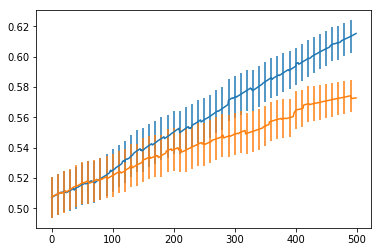

In [72]:
from matplotlib import pyplot as plt
import numpy as np

#metric = 'c-index-valid-soft'
#metric = 'c-index-soft'

metric = 'c-index-valid-hard'
#metric = 'c-index-hard'



results = []
    
for out in output:
        
        results.append(out[metric])
        
res = np.mean(results, axis=0)
reserr = 1.96*(np.std(results,axis=0 )/np.sqrt(len(output)))
    
plt.errorbar(range(len(res)), res,   yerr=reserr, errorevery=10, c='C0')


results_rt = []
    
for out in output_rt:
        
        if len(out[metric]) != 500:
            
            continue
        
        results_rt.append(out[metric])
        
        

res = np.mean(results_rt, axis=0)
reserr = 1.96*(np.std(results,axis=0 )/np.sqrt(len(output_rt)))
    
plt.errorbar(range(len(res)), res,   yerr=reserr,  errorevery=10,  c='C1')




500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
219
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [114]:
from matplotlib import pyplot as plt
plt.plot(met['elbo']['c-index-soft'])
plt.plot(metrics['c-index-soft'])


KeyError: 'elbo'

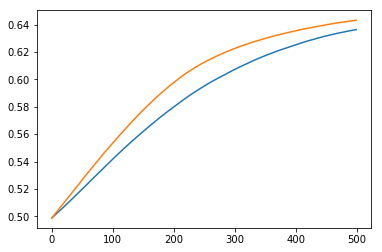

In [164]:
from matplotlib import pyplot as plt
import numpy as np

for typ in ['elbo', 'rt']:
    
    results = []
    
    for seed in met.keys():
        

        results.append(met[seed][typ]['c-index-soft'])
        
    res = np.mean(results, axis=0)
    reserr = 1.96*(np.std(results,axis=0 )/np.sqrt(len(met)))
    
    plt.plot(res)


In [165]:
met[0]['elbo'].keys()

['train_loss',
 'c-index-valid-hard',
 'valid_loss',
 'c-index-soft',
 'c-index-valid-soft',
 'c-index-hard',
 'c-index-test-soft',
 'c-index-test-hard',
 'test_loss']

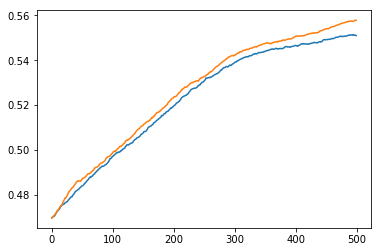

In [167]:
from matplotlib import pyplot as plt
import numpy as np

for typ in ['elbo', 'rt']:
    
    results = []
    
    for seed in met.keys():
        

        results.append(met[seed][typ]['c-index-valid-soft'])
        
    res = np.mean(results, axis=0)
    reserr = 1.96*(np.std(results,axis=0 )/np.sqrt(len(met)))
    
    plt.plot(res)


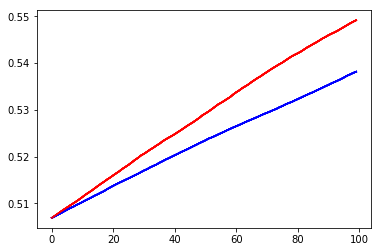

In [139]:

for seed in range(10):

    plt.plot(met[seed]['elbo']['c-index-soft'], c='b')
    plt.plot(met[seed]['rt']['c-index-soft'], c='r')

In [138]:
met[1]

{'elbo': {'c-index-hard': [0.5070634258593413,
   0.5071658277002733,
   0.5073154034229829,
   0.5074810873004458,
   0.5076272112757083,
   0.5077951963181361,
   0.5079505249532575,
   0.5081196605781677,
   0.508268085718395,
   0.508418812023587,
   0.508554580756508,
   0.5086915000719114,
   0.5088301452610384,
   0.5090021573421545,
   0.5091402272400403,
   0.5092667913131023,
   0.5094037106285056,
   0.5095061124694377,
   0.5096292247950525,
   0.5097672946929384,
   0.5098823529411765,
   0.5100181216740975,
   0.510173450309219,
   0.5103448870990939,
   0.5104737523371207,
   0.5105934129152884,
   0.5107199769883504,
   0.5109075219329786,
   0.5110996692075364,
   0.5112181792032217,
   0.5113953689055084,
   0.5115863655975837,
   0.5117543506400115,
   0.511870559470732,
   0.5119867683014526,
   0.5121282899467856,
   0.5122962749892133,
   0.5124274413922048,
   0.5126287933266216,
   0.512741550409895,
   0.5129118366172875,
   0.5130947792319862,
   0.51326851718

In [133]:
met[0].keys()

['rt']

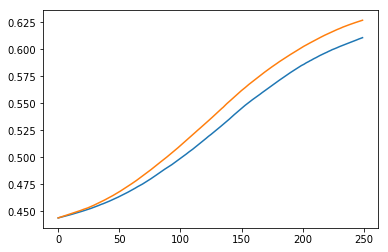

In [127]:
from matplotlib import pyplot as plt
plt.plot(met['elbo']['c-index-soft'])
plt.plot(met['rt']['c-index-soft'])


In [85]:
from matplotlib import pyplot as plt
plt.plot(met['elbo']['c-index-valid-soft'])
plt.plot(metrics['c-index-valid-soft'])


KeyError: 'c-index-valid-soft'

In [211]:
print(np.std(metrics['c-index-test-soft'][-1])/np.sqrt(250) )
print(np.std(metrics['c-index-test-hard'][-1]))

0.0005685392747076862
0.00940699730035032


In [70]:
metrics['test_loss']

[tensor(655.7275, grad_fn=<NegBackward>)]

In [66]:
#grid search:

linear_models=[2,5,7,10]
learning_rates=[1e-4,1e-3]
best_k_hard=0
best_lr_hard=0
best_k_soft=0
best_lr_soft=0

best_ci_soft=0
best_ci_hard=0

for k in linear_models:
    for lr in learning_rates:
        n_in = x_train.shape[1]
        betas_network = nn.Sequential(nn.Linear(n_in, k, bias=False) )
        betas_network.apply(init_weights)

    # Construct Neural Network
        layers_sizes = [n_in,20,20, k]
        layers = []
        for i in range(len(layers_sizes)-2):
            layers.append(nn.Linear(layers_sizes[i],layers_sizes[i+1], ))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(layers_sizes[-2], layers_sizes[-1], bias=False))
        gated_network = nn.Sequential(*layers)
        gated_network.apply(init_weights)

    #optimizer = optimizer = torch.optim.SGD(my_network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=L2_reg, nesterov=True)
        optimizer = torch.optim.Adam(list(gated_network.parameters()) + list(betas_network.parameters()), lr=lr)
    
        if CUDA:
            gated_network.cuda()
            betas_network.cuda()

    # If you have validation data, you can add it as the valid_dataloader parameter to the function
        n_epochs = 1
        metrics = train(gated_network, betas_network, risk_set, x_train, e_train, t_train,  risk_set_valid, x_valid, e_valid, t_valid, CUDA, optimizer, n_epochs,x_test,e_test,t_test,risk_set_test)
        print() 
        print("Models:",k)
        print("Learning Rate:",lr)
    
        print(metrics['c-index-soft'][-1])
        print(metrics['c-index-hard'][-1])
        print(metrics['c-index-test-soft'][-1])
        print(metrics['c-index-test-hard'][-1])
    
        if metrics['c-index-test-soft'][-1]>best_ci_soft:
            best_ci_soft=metrics['c-index-test-soft'][-1]
            best_k_soft=k
            best_lr_soft=lr

        if metrics['c-index-test-hard'][-1]>best_ci_hard:
            best_ci_hard=metrics['c-index-test-hard'][-1]
            best_k_hard=k
            best_lr_hard=lr
        
print('Best Concordance for hard gating:',best_ci_hard, "with parameters:" )
print('Learning rate-',best_lr_hard)
print('Linear models-',best_k_hard)

print('Best Concordance for hard gating:',best_ci_soft, "with parameters:" )
print('Learning rate-',best_lr_soft)
print('Linear models-',best_k_soft)



Models: 2
Learning Rate: 0.0001
0.7255547232830286
0.6858012942519984
0.5873404474013717
0.5765759031191015




Models: 2
Learning Rate: 0.001
0.4040571239117354
0.2796075493940101
0.4559606795118578
0.5238744884038199




Models: 5
Learning Rate: 0.0001
0.72298832226138
0.7192799341822513
0.5957689360668299
0.5680726606739053




Models: 5
Learning Rate: 0.001
0.6618318454756438
0.6204968257671575
0.5651946401539928
0.5577379506251284




Models: 7
Learning Rate: 0.0001
0.6767046919704802
0.49711556172255855
0.5864994673793194
0.49879459530172493




Models: 7
Learning Rate: 0.001
0.6336284489851051
0.6898756093667497
0.6007026855295371
0.5790054009605861




Models: 10
Learning Rate: 0.0001
0.5495831133268662
0.3088866240161106
0.5323216655142126
0.5483376628230765




Models: 10
Learning Rate: 0.001
0.33140955585299064
0.25734002971622233
0.4249752378104618
0.5030555607467903
Best Concordance for hard gating: 0.5790054009605861 with parameters:
Learning rate- 0.001
Linear models- 7
Best Concordance for hard gating: 0.6007026855295371 with parameters:
Learning rate- 0.001
Linear models- 7


In [27]:
print(np.max(metrics['c-index-valid-soft']))
print(np.max(metrics['c-index-valid-hard']))


0.7847247969260844
0.5149482624962082


('num of epochs: ', 500)


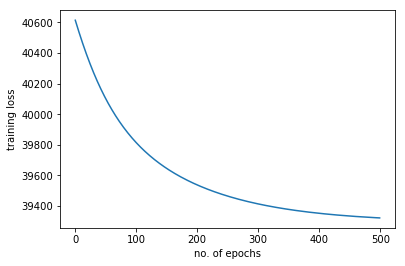

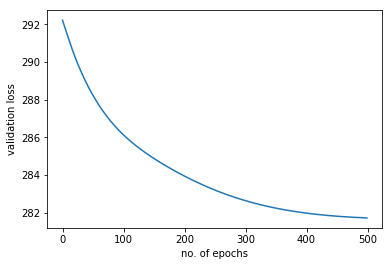

KeyError: 'c-index-valid-soft'

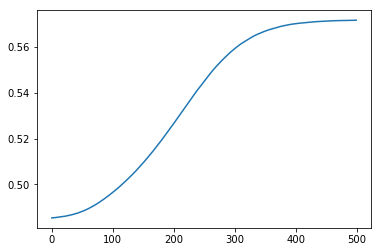

In [212]:
# Print the final metrics
# print('Train C-Index:', metrics['c-index'])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

print("num of epochs: ", len(metrics['train_loss']))
# print(metrics['train_loss'])
# Plot the training / validation curves
plt.plot(range(len(metrics['train_loss'])), metrics['train_loss'])
plt.xlabel('no. of epochs')
plt.ylabel('training loss')
plt.show()

plt.plot(range(len(metrics['valid_loss'])), metrics['valid_loss'])
plt.xlabel('no. of epochs')
plt.ylabel('validation loss')
plt.show()


plt.plot(range(len(metrics['c-index-soft'])), metrics['c-index-soft'])
plt.plot(range(len(metrics['c-index-valid-soft'])), metrics['c-index-valid-soft'])

plt.xlabel('no. of epochs')
plt.ylabel('concordance index')
# plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.xscale('linear')
plt.show()


plt.plot(range(len(metrics['c-index-hard'])), metrics['c-index-hard'])
plt.plot(range(len(metrics['c-index-valid-hard'])), metrics['c-index-valid-hard'])

plt.xlabel('no. of epochs')
plt.ylabel('concordance index')
# plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.xscale('linear')
plt.show()

In [357]:
from lifelines import CoxPHFitter


In [358]:
ds

,0,1,2,3,4,5,lenfol,fstat
0,1.0,84.0,0.0,22.44662,1.0,1.0,7.589239,1
1,0.0,36.0,0.0,31.64232,0.0,1.0,1266.000000,0
2,0.0,76.0,0.0,46.48160,0.0,1.0,1453.000000,0
3,0.0,47.0,1.0,27.58821,1.0,0.0,608.000000,0
4,0.0,80.0,0.0,24.12942,1.0,0.0,22.616980,1
5,0.0,77.0,0.0,23.67519,0.0,0.0,1313.000000,0
6,0.0,90.0,1.0,27.46412,1.0,0.0,1.423138,1
7,0.0,80.0,1.0,29.26457,1.0,0.0,1567.236000,1
8,0.0,40.0,0.0,25.46070,0.0,0.0,1349.000000,0
9,0.0,54.0,1.0,24.41255,1.0,1.0,278.901600,1


In [56]:
CoxPHFitter().fit(ds.iloc[], 'lenfol', 'fstat')

/home/cnagpal/anaconda2/lib/python2.7/site-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column 0 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['fstat'].astype(bool)
>>> df.loc[events, '0'].var()
>>> df.loc[~events, '0'].var()

Too low variance here means that the column 0 completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 1638 observations, 948 censored>

In [60]:
events = ds['fstat'].astype(bool)
ds.loc[events, '0'].var()
ds.loc[~events, '0'].var()



0.0